# COVID-19 Data Analysis
**Joe Corliss**

[Data source](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

## Execution Options

In [1063]:
# Config
DATA_PATH = '../data/'
random_state = 0

# Modeling
metric = 'confirmed'  # Variable of interest
metric_min = {'confirmed': round(2**6), 'deaths': round(2**3)}  # Filter out samples where the metric is below this value
log_metric = True  # Take log of the metric?
days_history = 16  # Number of consecutive past days to use for prediction (including the current day)
days_horizon = 7  # Number of days ahead to predict

In [1064]:
# Validate input
assert isinstance(DATA_PATH, str), "Bad input for option 'DATA_PATH'"
assert isinstance(random_state, int), "Bad input for option 'random_state'"
assert metric in {'confirmed', 'deaths'}, "Bad input for option 'metric'"
assert isinstance(metric_min, dict), "Bad input for option 'metric_min'"
assert isinstance(log_metric, bool), "Bad input for option 'log_metric'"
assert isinstance(days_history, int) and days_history >= 1, "Bad input for option 'days_history'"
assert isinstance(days_horizon, int) and days_horizon >= 1, "Bad input for option 'days_horizon'"

## Imports

In [1065]:
import sys

In [1066]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [1067]:
# Check package versions
assert sys.version[:3] == '3.6', 'Unexpected Python version: expected 3.6, got {}'.format(sys.version[:3])
assert mpl.__version__.rpartition('.')[0] == '3.1', 'Unexpected matplotlib version: expected 3.1, got {}'.format(mpl.__version__.rpartition('.')[0])
assert np.__version__.rpartition('.')[0] == '1.18', 'Unexpected numpy version: expected 1.18, got {}'.format(np.__version__.rpartition('.')[0])
assert pd.__version__.rpartition('.')[0] == '1.0', 'Unexpected pandas version: expected 1.0, got {}'.format(pd.__version__.rpartition('.')[0])
assert sklearn.__version__.rpartition('.')[0] == '0.22', 'Unexpected scikit-learn version: expected 0.22, got {}'.format(sklearn.__version__.rpartition('.')[0])

In [1068]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [1069]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

## Load data

In [1070]:
values = pd.read_csv(DATA_PATH + 'time_series_covid19_{metric}_global.txt'.format(metric=metric))

In [1071]:
print('Data updated to:', values.columns[-1])

Data updated to: 4/4/20


In [1072]:
values.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  81 non-null     object 
 1   Country/Region  259 non-null    object 
 2   Lat             259 non-null    float64
 3   Long            259 non-null    float64
 4   1/22/20         259 non-null    int64  
 5   1/23/20         259 non-null    int64  
 6   1/24/20         259 non-null    int64  
 7   1/25/20         259 non-null    int64  
 8   1/26/20         259 non-null    int64  
 9   1/27/20         259 non-null    int64  
 10  1/28/20         259 non-null    int64  
 11  1/29/20         259 non-null    int64  
 12  1/30/20         259 non-null    int64  
 13  1/31/20         259 non-null    int64  
 14  2/1/20          259 non-null    int64  
 15  2/2/20          259 non-null    int64  
 16  2/3/20          259 non-null    int64  
 17  2/4/20          259 non-null    int

Check that there is no unexpected missing data:

In [1073]:
assert values.notnull().all()[1:].all(), 'Unexpected missing data!'

In [1074]:
values.drop(columns={'Lat', 'Long'}, inplace=True)

In [1075]:
values.rename(columns={'Country/Region': 'country', 'Province/State': 'province'}, inplace=True)

In [1076]:
values.sample(5)

,province,country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
141,NaN,Kazakhstan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,9,10,33,35,44,49,53,60,62,72,81,111,150,228,284,302,343,380,435,464,531
30,NaN,Bulgaria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,7,7,23,41,51,52,67,92,94,127,163,187,201,218,242,264,293,331,346,359,399,422,457,485,503
215,NaN,Ukraine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,14,14,16,29,47,73,73,97,145,196,310,356,475,548,645,794,897,1072,1225
190,NaN,Saint Vincent and the Grenadines,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,7
103,NaN,Eswatini,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,4,4,4,4,6,9,9,9,9,9,9,9,9,9


## Look at Countries Split Up by Province/State

Number of distinct provinces for countries with more than one province:

In [1077]:
country_counts = values['country'].value_counts()
print(country_counts[country_counts > 1])

China             33
Canada            15
United Kingdom    11
France            10
Australia          8
Netherlands        5
Denmark            3
Name: country, dtype: int64


List current value by country and province, sorted by country ascending, then value descending:

In [1078]:
values.loc[values['country'].map(country_counts > 1)].iloc[:, [1, 0, -1]].sort_values(
    ['country', values.columns[-1]], ascending=[True, False]
)

,country,province,4/4/20
9,Australia,New South Wales,2493
14,Australia,Victoria,1115
11,Australia,Queensland,900
15,Australia,Western Australia,436
12,Australia,South Australia,407
8,Australia,Australian Capital Territory,93
13,Australia,Tasmania,80
10,Australia,Northern Territory,26
44,Canada,Quebec,6101
42,Canada,Ontario,3630


## Data Processing

Add a new variable `locale` that combines the country and provice (if applicable):

In [1079]:
values.insert(0, 'locale', values['country'].where(
    values['province'].isnull(),
    values['country'] + '/' + values['province']
))

Replaces the `country` and `province` columns:

In [1080]:
values.drop(columns={'province', 'country'}, inplace=True)

In [1081]:
values.sample(5)

,locale,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
81,China/Zhejiang,10,27,43,62,104,128,173,296,428,538,599,661,724,829,895,954,1006,1048,1075,1092,1117,1131,1145,1155,1162,1167,1171,1172,1174,1175,1203,1205,1205,1205,1205,1205,1205,1205,1205,1205,1206,1213,1213,1215,1215,1215,1215,1215,1215,1215,1215,1215,1227,1231,1231,1232,1232,1233,1234,1236,1238,1238,1240,1241,1243,1247,1251,1254,1255,1257,1257,1258,1260,1262
22,Belarus,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,6,6,6,6,6,6,9,9,12,27,27,27,36,36,51,51,69,76,76,81,81,86,86,94,94,94,152,152,163,304,351,440
251,United Kingdom/Turks and Caicos Islands,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,5,5,6,5,5,5
13,Australia/Tasmania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,3,3,5,5,6,7,7,10,10,10,16,22,28,28,36,47,47,62,66,66,69,69,72,74,80
42,Canada/Ontario,0,0,0,0,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,6,6,11,15,18,20,20,22,25,28,29,34,36,41,42,74,79,104,177,185,221,257,308,377,425,503,588,688,858,994,1144,1355,1706,1966,2392,2793,3255,3630


Plot values for each locale (repeat the second cell below):

In [1082]:
idx = 0

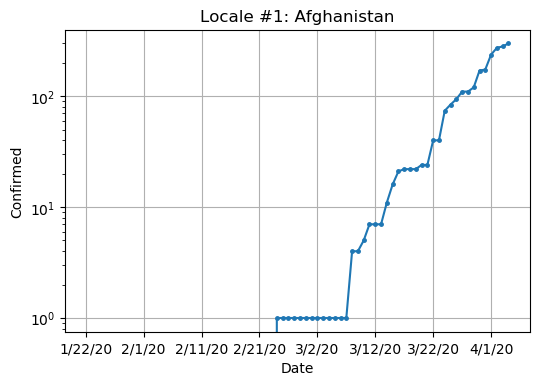

In [1083]:
if idx < values.shape[0]:
    while values.iloc[idx, -1] < 100:
        idx += 1
    plt.figure(dpi=100)
    values.iloc[idx, 1:].plot.line(marker='.', markersize=5, logy=log_metric)
    plt.title('Locale #{idx}: {locale}'.format(idx=idx + 1, locale=values.iloc[idx, 0]))
    plt.xlabel('Date')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    idx += 1

Stack the data:

In [1084]:
values_melt = values.melt(id_vars=['locale'], var_name='date', value_name='value')

In [1085]:
values_melt['date'] = pd.to_datetime(values_melt['date'])

In [1086]:
values_melt.sample(5)

,locale,date,value
18280,Lithuania,2020-04-01,581
6487,Australia/South Australia,2020-02-16,2
11844,Saint Lucia,2020-03-07,0
4134,United Kingdom/Anguilla,2020-02-06,0
3052,Sudan,2020-02-02,0


Filter by the minimum required metric value:

In [1087]:
values_melt = values_melt.loc[values_melt['value'] >= metric_min[metric]]

Apply log to the metric values, if specified:

In [1088]:
if log_metric:
    values_melt['value'] = values_melt['value'].map(np.log10)

In [1089]:
values_melt.sample(5)

,locale,date,value
18839,San Marino,2020-04-03,2.389166
18087,United Arab Emirates,2020-03-31,2.822168
19100,Senegal,2020-04-04,2.340444
14689,Qatar,2020-03-18,2.655138
7302,China/Beijing,2020-02-19,2.594393


## Construct Final Datasets

In [1090]:
final_schema = pd.DataFrame(columns=['locale', 'date']
                                    + ['value_d{}'.format(idx) for idx in range(-days_history + 1, 1)]
                                    + ['value_d+{}'.format(days_horizon)])

In [1091]:
final_schema

,locale,date,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7


In [1092]:
train_to_append_list = []
pred_to_append_list = []

In [1093]:
for locale in sorted(values_melt['locale'].unique()):
    values_melt_locale = values_melt.loc[values_melt['locale'] == locale].sort_values('date')
    
    # Add to training data
    for idx in range(values_melt_locale.shape[0] - days_history - days_horizon + 1):
        train_to_append = values_melt_locale.iloc[idx + (days_history - 1), :2].to_dict()
        train_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[idx : idx + days_history]))
        train_to_append[final_schema.columns[-1]] = values_melt_locale['value'].iloc[idx + (days_history - 1) + days_horizon]
        train_to_append_list.append(train_to_append)
        
    # Add to prediction data
    if days_history <= values_melt_locale.shape[0]:  # Can only predict if we have enough days of history
        pred_to_append = values_melt_locale.iloc[-1, :2].to_dict()
        pred_to_append.update(zip(final_schema.columns[2:-1], values_melt_locale['value'].iloc[-days_history:]))
        pred_to_append_list.append(pred_to_append)

In [1094]:
train = final_schema.append(train_to_append_list, ignore_index=True)
pred = final_schema.append(pred_to_append_list, ignore_index=True)

In [1095]:
train = train.sample(frac=1, random_state=random_state)
train = train.sort_values('date')

In [1096]:
train.set_index(['locale', 'date'], inplace=True, verify_integrity=True)
pred.set_index(['locale', 'date'], inplace=True, verify_integrity=True)

In [1097]:
train.head()

value_d-15  value_d-14  value_d-13  value_d-12  \
locale          date                                                         
China/Hubei     2020-02-06    2.647383    2.647383    2.739572    2.881385   
                2020-02-07    2.647383    2.739572    2.881385    3.024486   
                2020-02-08    2.739572    2.881385    3.024486    3.153205   
China/Guangdong 2020-02-09    1.892095    2.045323    2.178977    2.315970   
China/Hubei     2020-02-09    2.881385    3.024486    3.153205    3.550717   

                            value_d-11  value_d-10  value_d-9  value_d-8  \
locale          date                                                       
China/Hubei     2020-02-06    3.024486    3.153205   3.550717   3.550717   
                2020-02-07    3.153205    3.550717   3.550717   3.690462   
                2020-02-08    3.550717    3.550717   3.690462   3.763877   
China/Guangdong 2020-02-09    2.442480    2.549003   2.639486   2.728354   
China/Hubei     2020-02-09    3.550717    3.690462   3.763877   3.854488   

                            value_d-7  value_d-6  value_d-5  value_d-4  \
locale          date                                                     
China/Hubei     2020-02-06   3.690462   3.763877   3.854488   4.048325   
                2020-02-07   3.763877   3.854488   4.048325   4.131041   
                2020-02-08   3.854488   4.048325   4.131041   4.222144   
China/Guangdong 2020-02-09   2.800717   2.860338   2.910091   2.951823   
China/Hubei     2020-02-09   4.048325   4.131041   4.222144   4.293694   

                            value_d-3  value_d-2  value_d-1  value_d0  \
locale          date                                                    
China/Hubei     2020-02-06   4.131041   4.222144   4.293694  4.344628   
                2020-02-07   4.222144   4.293694   4.344628  4.397123   
                2020-02-08   4.293694   4.344628   4.397123  4.432969   
China/Guangdong 2020-02-09   2.986772   3.014521   3.039414  3.053463   
China/Hubei     2020-02-09   4.344628   4.397123   4.432969  4.471746   

                            value_d+7  
locale          date                   
China/Hubei     2020-02-06   4.683101  
                2020-02-07   4.735647  
                2020-02-08   4.750115  
China/Guangdong 2020-02-09   3.119256  
China/Hubei     2020-02-09   4.764789

In [1098]:
pred.head()

,,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,,,
Albania,2020-04-04,1.845098,1.880814,1.949390,2.017033,2.089905,2.164353,2.240549,2.269513,2.294466,2.326336,2.348305,2.385606,2.413300,2.442480,2.482874,2.522444,NaN
Algeria,2020-04-04,1.954243,2.143015,2.303196,2.361728,2.421604,2.480007,2.564666,2.611723,2.657056,2.708421,2.766413,2.854913,2.927883,2.993877,3.068557,3.097257,NaN
Andorra,2020-04-04,1.875061,1.944483,2.053078,2.123852,2.214844,2.274158,2.350248,2.426511,2.488551,2.523746,2.568202,2.575188,2.591065,2.631444,2.642465,2.668386,NaN
Argentina,2020-04-04,2.107210,2.198657,2.424882,2.478566,2.587711,2.587711,2.700704,2.770115,2.838849,2.872156,2.913814,3.022841,3.022841,3.054230,3.102091,3.161667,NaN
Armenia,2020-04-04,2.133539,2.204120,2.287802,2.371068,2.396199,2.423246,2.462398,2.517196,2.609594,2.627366,2.683047,2.725912,2.756636,2.821514,2.866878,2.886491,NaN


Check the size of the dataset:

In [1099]:
print('The training data has {} samples'.format(train.shape[0]))
print('Predictions will be made for {} locales'.format(pred.shape[0]))

The training data has 1615 samples
Predictions will be made for 120 locales


## Model Training and Validation

In [1100]:
# model = linear_model.LassoCV(
#     eps=1e-8,
#     fit_intercept=True,
#     max_iter=100000,
#     n_jobs=-1,
#     random_state=random_state,
# )

In [1101]:
model = linear_model.ElasticNetCV(
    l1_ratio=[pow(x, 1/3) for x in np.linspace(0.001, 1, 10)],
    eps=1e-8,
    n_alphas=100,
    fit_intercept=True,
    max_iter=100000,
    cv=TimeSeriesSplit(),
    n_jobs=-1,
    random_state=random_state,
    selection='random',
)

In [1102]:
model.fit(train.iloc[:, :-1], train.iloc[:, -1])

ElasticNetCV(alphas=None, copy_X=True,
             cv=TimeSeriesSplit(max_train_size=None, n_splits=5), eps=1e-08,
             fit_intercept=True,
             l1_ratio=[0.10000000000000002, 0.48202845283504603,
                       0.6064126994506963, 0.6938232073815802,
                       0.763460672149231, 0.822289851862149, 0.8737260372210359,
                       0.9197289686814338, 0.961539774357182, 1.0],
             max_iter=100000, n_alphas=100, n_jobs=-1, normalize=False,
             positive=False, precompute='auto', random_state=0,
             selection='random', tol=0.0001, verbose=0)

In [1103]:
model.coef_

array([ 1.21161693e-01, -0.00000000e+00, -4.55854675e-02, -1.27282278e-01,
        6.88722296e-02,  8.23826433e-04,  0.00000000e+00,  9.96602725e-03,
       -1.36744529e-01, -3.58531195e-01, -0.00000000e+00, -2.41930548e-01,
       -3.69221599e-01, -2.67824581e-01,  4.57429621e-03,  2.33459471e+00])

In [1104]:
model.intercept_

0.025375406854936777

In [1105]:
if isinstance(model, sklearn.linear_model._coordinate_descent.ElasticNetCV):
    print(model.l1_ratio_)

1.0


In [1106]:
model.alpha_

5.369299532325525e-06

In [1107]:
# min(model.alphas_), max(model.alphas_)

Cross-validated mean absolute error:

In [1108]:
mean_abs_errors = -cross_val_score(
    estimator=linear_model.ElasticNet(
        alpha=model.alpha_,
        l1_ratio=model.l1_ratio_,
        max_iter=100000,
        random_state=random_state,
        selection='random',
    ),
    X=train.iloc[:, :-1],
    y=train.iloc[:, -1],
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(),
    n_jobs=-1,
)

In [1109]:
sorted(mean_abs_errors)

[0.018369613039692808,
 0.019635271034337272,
 0.032022496217042014,
 0.03909285708585287,
 0.042350373142824756]

## Model Selection Information

In [1110]:
pd.DataFrame(
    data={
        'days_history': days_history,
        'days_selected': (model.coef_ != 0).sum(),
        'metric_min': metric_min[metric],
        'n_samples': train.shape[0],
        'samples_per_param': train.shape[0]/(days_history + 1),
        'mean_error': mean_abs_errors.mean(),
    },
    index=[0],
)

,days_history,days_selected,metric_min,n_samples,samples_per_param,mean_error
0,16,13,64,1615,95.0,0.030294


## Predictions

In [1111]:
pred['value_d+{}'.format(days_horizon)] = model.predict(pred.iloc[:, :-1])

In [1112]:
if log_metric:
    for col in pred.columns:
        pred[col] = pred[col].map(lambda x: round(10**x))

In [1113]:
pred

,,value_d-15,value_d-14,value_d-13,value_d-12,value_d-11,value_d-10,value_d-9,value_d-8,value_d-7,value_d-6,value_d-5,value_d-4,value_d-3,value_d-2,value_d-1,value_d0,value_d+7
locale,date,,,,,,,,,,,,,,,,,
Albania,2020-04-04,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,503
Algeria,2020-04-04,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,2445
Andorra,2020-04-04,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,602
Argentina,2020-04-04,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265,1451,2370
Armenia,2020-04-04,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736,770,1230
Australia/New South Wales,2020-04-04,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389,2493,3070
Australia/Queensland,2020-04-04,184,221,259,319,397,443,493,555,625,656,689,743,781,835,873,900,1129
Australia/Victoria,2020-04-04,121,229,355,355,411,466,520,574,685,769,821,917,968,1036,1085,1115,1335
Australia/Western Australia,2020-04-04,64,90,120,140,175,175,231,231,278,311,355,364,392,400,400,436,535
